In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Read in data files and parse dates

## Google Drive storage location for date-limited data files:
https://drive.google.com/open?id=0B_PnWx1pRhmzNWxYNDVjWjBNcnc

crime_df source data:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2

weather_df source data:
www.wunderground.com/history

[astronomics] ---not yet a part of this base file; please update with how it's being used
http://aa.usno.navy.mil/data/index.php

In [2]:
# Make sure data files are in the same folder
# Add any additional read-in statements here
# This takes a while because of the datetime conversion in crime_df (over a million lines)

weather_df = pd.read_csv("Chicago Weather Data 2011-2015.csv")
weather_df.rename(columns={'CST':'Date'}, inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date']).dt.date

crime_df = pd.read_csv("Chicago Crime 2011-2015.csv")
crime_df['Date'] = pd.to_datetime(crime_df['Date']).dt.date

## weather_df modifications

Since weather_df is already organized as a single day for every line, it is useful to add columns that will make
further analysis easier.

In [3]:
# Some columns in weather_df get imported with a leading space
# This removes those spaces

newcols = []
for i in weather_df.columns:
    if i[0] == ' ':
        i = i[1:]
    newcols.append(i)

weather_df.columns = newcols

In [4]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
# Apply map to new column
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [5]:
# weatherunderground uses a scale of 0 to 9 to represent cloud cover
# I'm saying that a "clear" day is one with a cloud cover of less than 3
weather_df['Clear'] = weather_df['CloudCover'].map(lambda x: int(x) < 3)

In [6]:
# Mapping function so that temps can be categorized into buckets
def temp_map(temp):
    if temp < 0:
        return 'below 0'
    else:
        return str((temp//10)*10) + 's'
    
weather_df['temp bucket'] = weather_df['Max TemperatureF'].map(temp_map)

In [7]:
# Create a list of each unique weather event type
eventlist = list(weather_df['Events'].unique())
neweventlist = []
for i in eventlist:
    i = str(i)
    neweventlist.append(i.split('-'))
eventlist = []
for i in neweventlist:
    for j in i:
        if j != 'nan':
            eventlist.append(j)
eventlist = list(set(eventlist))

# Create a new column in the weather dataframe for each item in the event list and populate with True or False for each day
for e in eventlist:
    weather_df[e] = weather_df['Events'].map(lambda x: e in str(x))

In [8]:
# Crimes per day seems like a pretty good thing to throw in there
dailycounts = crime_df.groupby('Date').size()
weather_df['crimes'] = weather_df.Date.map(lambda x: dailycounts[x])

In [9]:
# A 'local' average is useful for picking out days that deviate from their immediately adjacent neighbors
# The local deviation is how each day compares to its neighbors
def get_local_avg(date,span=7,df=weather_df):
    return df[(df['Date'] < date + datetime.timedelta(days=span/2)) & 
              (df['Date'] > date - datetime.timedelta(days=span/2)) &
              (df['Date'] != date)]['crimes'].mean()

weather_df['localavg'] = weather_df.Date.map(get_local_avg)
weather_df['localdeviation'] = weather_df['crimes']/weather_df['localavg'] - 1

In [10]:
# It's useful to be able to reference the day of the month readily
weather_df['day'] = weather_df.Date.map(lambda x: x.day)

In [11]:
# It's also useful to know which day of the week it is
weather_df['dow'] = weather_df.Date.map(lambda x: x.weekday())

## Merge DataFrames

In [12]:
# Left-join crime and weather dataframes (crime on the left)
combined = pd.merge(crime_df, weather_df, how='left', on='Date')

# 1) Is crime more likely in warm or cold weather?

In [13]:
# Scott

# 2) Is crime more likely during pleasant or storm weather?

In [14]:
# Scott

# 3) Are certain phases of the moon related to higher crime rates?

In [15]:
# Lisa

# 4) Which criminal activities become more or less likely during specific weather events?

In [16]:
# TBD

# 5) Is crime influenced more by weather or by season?

In [17]:
# TBD

# 6) Is crime less likely to occur on holidays?

So, the thought here is similar to the "fewer crimes during bad weather" hypothesis.  People are usually hanging out with their family on Xmas and Thanksgiving, for example, and are less likely to be breaking into houses.  Initially, I just plotted the holidays against the average crime per day and it did show a decrease.  However, Scott brought up a great question: how do we know that these days don't just have fewer crimes since they're generally in the colder months (temperature being a confounding variable).  To address that question, I compared the holiday arrest average against the average number of arrests in the surrounding days see if the decrease was still there.  It was!

In [18]:
# Total Crimes
total_crimes = len(combined)
print(total_crimes)

1528075


In [19]:
# of days in the dataset
numdays = len(weather_df.Date)
print(numdays)

1826


In [20]:
# Avg number of crimes per day in Chicago
print(total_crimes / numdays)

836.84282584885


In [21]:
# Created a dataframe of crime grouped by date
crime_by_day = pd.DataFrame(combined.groupby("Date").size())

# Got the date out of the index, because I find the inconsistencies
# between dealing with the index and a column to be annoying.
crime_by_day = crime_by_day.reset_index()
crime_by_day.columns = ['Date', 'Count']

# Made lists of the dates for each of the holidays
xmas_dates = [datetime.date(2011, 12, 25), datetime.date(2012, 12, 25),
              datetime.date(2013, 12, 25), datetime.date(2014, 12, 25),
              datetime.date(2015, 12, 25)]

tg_dates = [datetime.date(2011, 11, 24), datetime.date(2012, 11, 22),
            datetime.date(2013, 11, 28), datetime.date(2014, 11, 27),
            datetime.date(2015, 11, 26)]

nye_dates = [datetime.date(2011, 12, 31), datetime.date(2012, 12, 31),
             datetime.date(2013, 12, 31), datetime.date(2014, 12, 31),
             datetime.date(2015, 12, 31)]

e_dates = [datetime.date(2011, 4, 24), datetime.date(2012, 4, 8),
           datetime.date(2013, 3, 31), datetime.date(2014, 4, 20),
           datetime.date(2015, 4, 5)]

# Calculated the average crime per day for each of the holidays
avgxmas = (crime_by_day[(crime_by_day["Date"] == xmas_dates[0]) |
                        (crime_by_day["Date"] == xmas_dates[1]) |
                        (crime_by_day["Date"] == xmas_dates[2]) |
                        (crime_by_day["Date"] == xmas_dates[3]) |
                        (crime_by_day["Date"] == xmas_dates[4])].mean().item())

avgtg = (crime_by_day[(crime_by_day["Date"] == tg_dates[0]) |
                      (crime_by_day["Date"] == tg_dates[1]) |
                      (crime_by_day["Date"] == tg_dates[2]) |
                      (crime_by_day["Date"] == tg_dates[3]) |
                      (crime_by_day["Date"] == tg_dates[4])].mean().item())

avgny = (crime_by_day[(crime_by_day["Date"] == nye_dates[0]) |
                      (crime_by_day["Date"] == nye_dates[1]) |
                      (crime_by_day["Date"] == nye_dates[2]) |
                      (crime_by_day["Date"] == nye_dates[3]) |
                      (crime_by_day["Date"] == nye_dates[4])].mean().item())

avge = (crime_by_day[(crime_by_day["Date"] == e_dates[0]) |
                     (crime_by_day["Date"] == e_dates[1]) |
                     (crime_by_day["Date"] == e_dates[2]) |
                     (crime_by_day["Date"] == e_dates[3]) |
                     (crime_by_day["Date"] == e_dates[4])].mean().item())


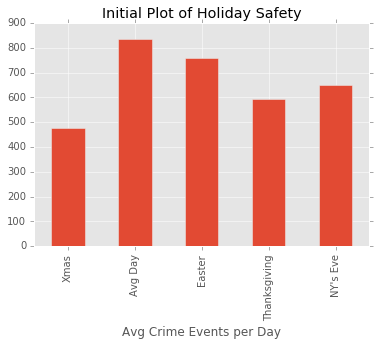

In [22]:
# The initial plot of average holiday crime vs. avg daily crime
# dicts rearrange things, so I used a list the next time around
plt.style.use('ggplot')
holidays_dict = {}
holidays_dict["Avg Day"] = total_crimes / numdays
holidays_dict["Xmas"] = avgxmas
holidays_dict["Thanksgiving"] = avgtg
holidays_dict["NY's Eve"] = avgny
holidays_dict["Easter"] = avge

holidays_df = pd.DataFrame.from_dict(holidays_dict, orient="index")
holidays_df.index.names = ['Avg Crime Events per Day']
holidays_df.plot(kind="bar", title='Initial Plot of Holiday Safety',
                 legend=False)


In [43]:
def grabcrime(year, month, day, df):
    ''' This takes in a dataframe and a date and returns the
        number of arrests that day.
    '''

    return df[df["Date"] == datetime.date(
            year, month, day)]["Count"].item()

# Track total crime around XMas
a_xmas_totals = 0

for y in [2011, 2012, 2013, 2014, 2015]:
    for d in [22, 23, 24, 26, 27, 28]:
        a_xmas_totals += grabcrime(y, 12, d, crime_by_day)

# I thought about trying to avoid this repetitive code
# but it's easy to read and understand.

a_tg_totals = 0

a_tg_totals += grabcrime(2011, 11, 21, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 22, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2011, 11, 27, crime_by_day)

a_tg_totals += grabcrime(2012, 11, 19, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 20, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 21, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2012, 11, 25, crime_by_day)

a_tg_totals += grabcrime(2013, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 27, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 29, crime_by_day)
a_tg_totals += grabcrime(2013, 11, 30, crime_by_day)
a_tg_totals += grabcrime(2013, 12, 1, crime_by_day)

a_tg_totals += grabcrime(2014, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 26, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 28, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 29, crime_by_day)
a_tg_totals += grabcrime(2014, 11, 30, crime_by_day)

a_tg_totals += grabcrime(2015, 11, 23, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 24, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 25, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 27, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 28, crime_by_day)
a_tg_totals += grabcrime(2015, 11, 29, crime_by_day)

# Track total crime around NYE
a_nye_totals = 0

for y in [2011, 2012, 2013, 2014]:
    for d in [28, 29, 30, 2, 3, 4]:
        if d > 20:
            m = 12
            yr = y
        else:
            m = 1
            yr = y + 1

        # print("Adding", yr, m, d)
        a_nye_totals += grabcrime(yr, m, d, crime_by_day)

# We don't have data for the days following the final NYE,
# so I just grabbed the preceding 6 days
a_nye_totals += grabcrime(2015, 12, 25, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 26, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 27, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 28, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 29, crime_by_day)
a_nye_totals += grabcrime(2015, 12, 30, crime_by_day)

# Track total crime around Easter
a_easter_totals = 0

a_easter_totals += grabcrime(2011, 4, 21, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 22, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 23, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 25, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 26, crime_by_day)
a_easter_totals += grabcrime(2011, 4, 27, crime_by_day)

a_easter_totals += grabcrime(2012, 4, 5, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 6, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 7, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 9, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 10, crime_by_day)
a_easter_totals += grabcrime(2012, 4, 11, crime_by_day)

a_easter_totals += grabcrime(2013, 3, 28, crime_by_day)
a_easter_totals += grabcrime(2013, 3, 29, crime_by_day)
a_easter_totals += grabcrime(2013, 3, 30, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 1, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 2, crime_by_day)
a_easter_totals += grabcrime(2013, 4, 3, crime_by_day)

a_easter_totals += grabcrime(2014, 4, 17, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 18, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 19, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 21, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 22, crime_by_day)
a_easter_totals += grabcrime(2014, 4, 23, crime_by_day)

a_easter_totals += grabcrime(2015, 4, 2, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 3, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 4, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 6, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 7, crime_by_day)
a_easter_totals += grabcrime(2015, 4, 8, crime_by_day)


In [44]:
# Created a dataframe with all of the stats to plot...
holidays_list = []
holidays_list.append(("Around XMas", a_xmas_totals / 30))
holidays_list.append(("Xmas", avgxmas))
holidays_list.append(("Around Thanksgiving", a_tg_totals / 30))
holidays_list.append(("Thanksgiving", avgtg))
holidays_list.append(("Around NY's Eve", a_nye_totals / 30))
holidays_list.append(("NY's Eve", avgny))
holidays_list.append(("Around Easter", a_easter_totals / 30))
holidays_list.append(("Easter", avge))

holidays_df = pd.DataFrame.from_records(
    holidays_list, index=["Around XMas", "XMas", "Around Thanksgiving",
                          "Thanksgiving", "Around NY's Eve", "NY's Eve",
                          "Around Easter", "Easter"],
    columns=["Desc", "Crimes per Day"])


Now we're ready to chart the holidays vs. their surrounding days to see if the decrease is real or just temperature-driven.

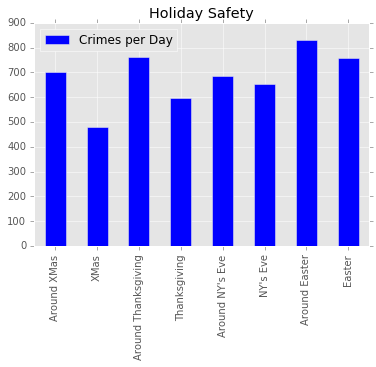

In [45]:
holidays_df.index.names = ['']
holidays_df.plot(kind="bar", title='Holiday Safety', legend=True,
                color=['b', 'b', 'r', 'r', 'g', 'g', 'y', 'y'])

# how to visually group holidays by color?

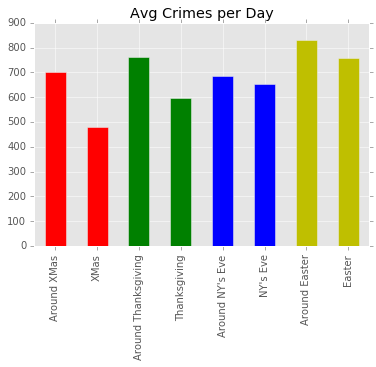

In [46]:
# For some reason, this worked...
holidays_df["group"] = [1,1,2,2,3,3,4,4]

holidays_df["Crimes per Day"].plot(kind='bar', title='Avg Crimes per Day', legend=False,
                                   color=['r', 'r', 'g', 'g', 'b', 'b', 'y', 'y'])

# 7) How has the crime rate changed over time? Is the change the same across all crime types?

So, despite all of the doom and gloom in the news these days, every once in awhile you hear a statistic about crime actually dropping in the last few decades.  I'd even heard somewhere that it's as safe now as it was in the "golden era" when our parents were kids and people didn't lock their doors.  However, I didn't know if it was continuing to drop or if it had reached a plateau.  Our data covered the last five calendar years in Chicago, so we had a great opportunity to answer that question.  It turns out that the answer is a big "yes, it is still dropping!"

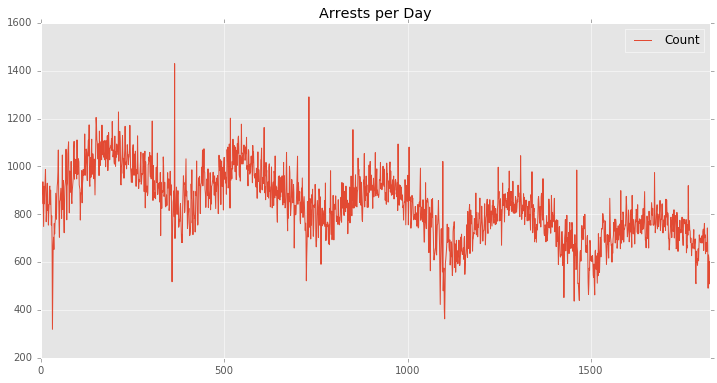

In [27]:
crime_by_day.plot(figsize=(12,6), title="Arrests per Day")

The next question is whether or not it's dropping for all types of crimes or just some of them.  Or maybe just the most common crime is dropping and it's giving the aggregate the impression that overall crime is decreasing.  In order to dig deeper, I looked at the top 10 most common crime types and charted them individually.

In [28]:
# Created a list of top 10 crime types
top10df = pd.DataFrame(combined["Primary Type"].value_counts().head(10))
top10df = top10df.reset_index()
top10list = list(top10df["index"].str.lower())
print("Top 10 most common crime types: ", top10list)

# Created a new column in the combined dataframe for
# each type of crime with True or False for each day
for c in top10list:
    combined[c] = combined['Primary Type'].map(
        lambda x: c in str(x).lower())


Top 10 most common crime types:  ['theft', 'battery', 'criminal damage', 'narcotics', 'burglary', 'assault', 'other offense', 'deceptive practice', 'motor vehicle theft', 'robbery']


In [29]:
combined.columns

Index(['Date', 'Block', 'Primary Type', 'Description', 'Location Description',
       'Arrest', 'Domestic', 'District', 'FBI Code', 'Max TemperatureF',
       'Mean TemperatureF', 'Min TemperatureF', 'Max Dew PointF',
       'MeanDew PointF', 'Min DewpointF', 'Max Humidity', 'Mean Humidity',
       'Min Humidity', 'Max Sea Level PressureIn', 'Mean Sea Level PressureIn',
       'Min Sea Level PressureIn', 'Max VisibilityMiles',
       'Mean VisibilityMiles', 'Min VisibilityMiles', 'Max Wind SpeedMPH',
       'Mean Wind SpeedMPH', 'Max Gust SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees', 'temp bucket', 'Clear', 'Fog',
       'Rain', 'Thunderstorm', 'Snow', 'Hail', 'crimes', 'localavg',
       'localdeviation', 'day', 'dow', 'theft', 'battery', 'criminal damage',
       'narcotics', 'burglary', 'assault', 'other offense',
       'deceptive practice', 'motor vehicle theft', 'robbery'],
      dtype='object')

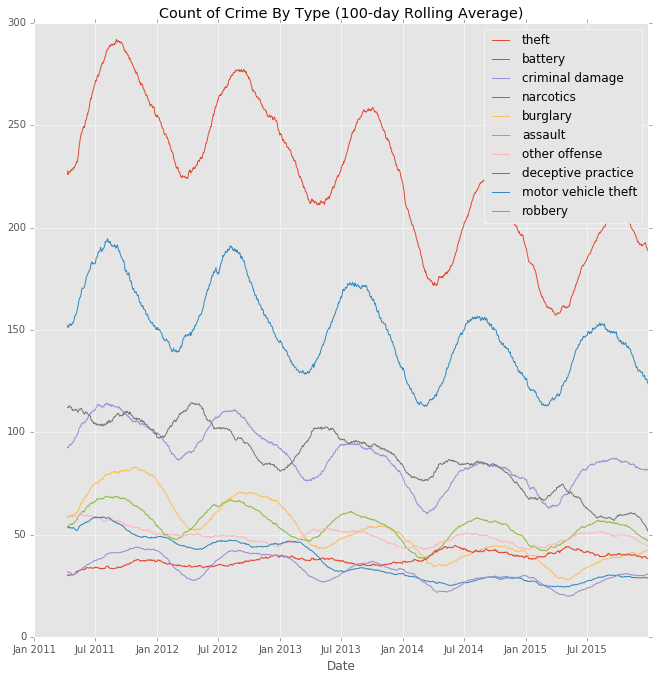

In [42]:
# Charting the arrests per day was too noisy.
# A rolling-average chart makes the downward trend more clear.
combined.groupby(["Date"])[top10list].sum().rolling(
    center=False, window=100).mean().plot(
    figsize=(11, 11),
    title="Count of Crime By Type (100-day Rolling Average)")


So, it appears that every single type of crime in the top 10 has been dropping in the last five years, with the exception of "deceptive practice."  So, what's that?

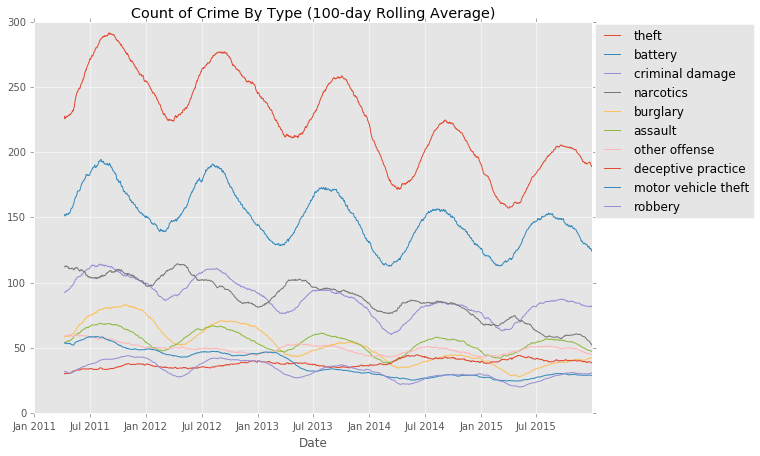

In [66]:
# How to keep the legend from covering the plot...
combined.groupby(["Date"])[top10list].sum().rolling(
    center=False, window=100).mean().plot(
    figsize=(10, 7),
    title="Count of Crime By Type (100-day Rolling Average)")

plt.legend(bbox_to_anchor=(1.3, 1.01))


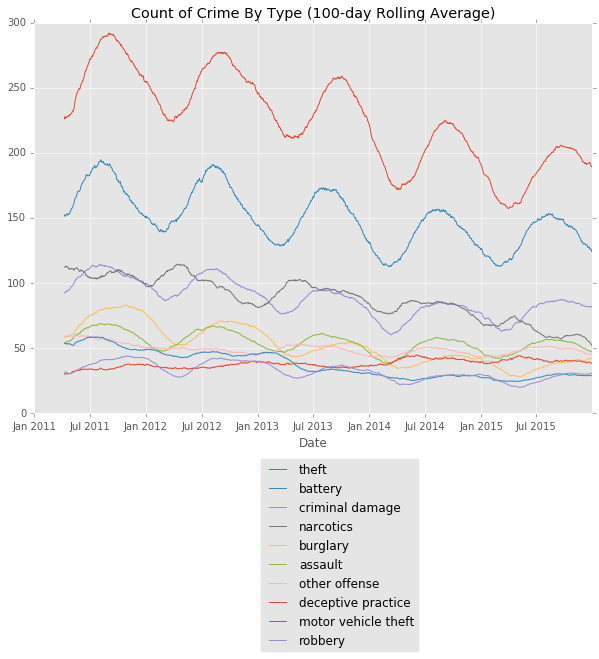

In [74]:
# How to keep the legend from covering the plot...
combined.groupby(["Date"])[top10list].sum().rolling(
    center=False, window=100).mean().plot(
    figsize=(10, 7),
    title="Count of Crime By Type (100-day Rolling Average)")

plt.legend(bbox_to_anchor=(0.7, -0.1))

In [31]:
combined[combined["Primary Type"] == "DECEPTIVE PRACTICE"][
    "Description"].value_counts()


CREDIT CARD FRAUD                          14658
ILLEGAL USE CASH CARD                       9867
THEFT OF LABOR/SERVICES                     8829
FINANCIAL IDENTITY THEFT OVER $ 300         8091
FRAUD OR CONFIDENCE GAME                    6976
FORGERY                                     2922
COUNTERFEITING DOCUMENT                     2850
BOGUS CHECK                                 2610
FINANCIAL IDENTITY THEFT $300 AND UNDER     2590
COUNTERFEIT CHECK                           2151
THEFT OF LOST/MISLAID PROP                  1914
ATTEMPT - FINANCIAL IDENTITY THEFT           926
THEFT BY LESSEE,MOTOR VEH                    776
COMPUTER FRAUD                               534
FINAN EXPLOIT-ELDERLY/DISABLED               467
STOLEN PROP: BUY/RECEIVE/POS.                451
UNLAWFUL USE OF RECORDED SOUND               387
DECEPTIVE COLLECTION PRACTICES               374
EMBEZZLEMENT                                 274
ILLEGAL POSSESSION CASH CARD                 256
AGGRAVATED FINANCIAL

There seem to be a few other types of crime that are not following the downward trend as well.  It's an interesting open question about what is different about these non-trending crime types.  Answering that may shed light on why almost all of the other types are decreasing.

Unfortunately, it turns out that offenses involving children and sexual assaults are two of the types of crime that don't have a clear downward trend.  It could be more due to the relatively low incident count per day in this dataset, which can make any trend hard to see.  Further study with nationwide statistics could answer this question definitively.

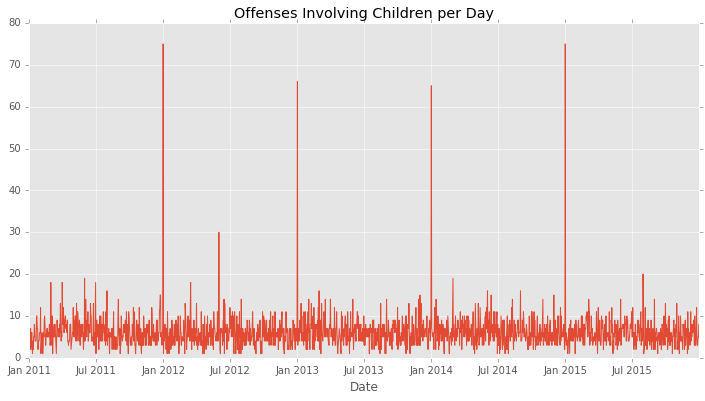

In [32]:
by_day = combined[combined['Primary Type'] ==
                  'OFFENSE INVOLVING CHILDREN'][['Date']].groupby(['Date'])
by_day_series = pd.Series(by_day.Date.count())
by_day_series.plot(figsize=(12, 6),
                   title="Offenses Involving Children per Day")


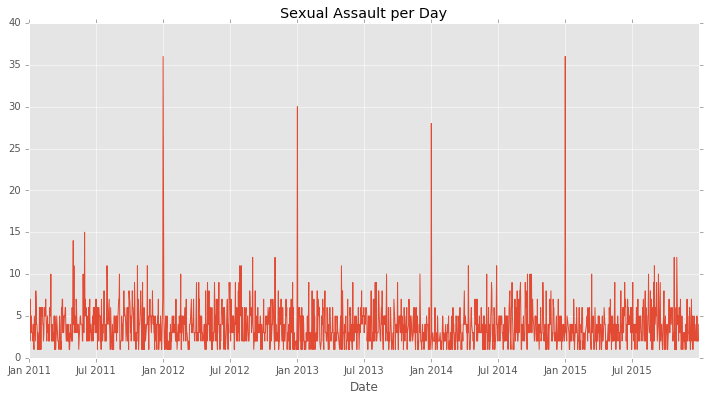

In [33]:
by_day = combined[combined['Primary Type'] == 'CRIM SEXUAL ASSAULT'][
    ['Date']].groupby(['Date'])
by_day_series = pd.Series(by_day.Date.count())
by_day_series.plot(figsize=(12, 6), title="Sexual Assault per Day")


# 8) Does the day of the month effect crime rate?

In [34]:
# Scott

# Sandbox
## Any other useful/relevant/interesting findings?

If you watch the news, not only will you not get the impression that crime is dropping around the country, you will also think that homicide is a very common thing.  According to this article:  http://dartcenter.org/content/violence-comparing-reporting-and-reality,
the Chicago Tribune crime section in the 1980s featured murder over 25% of the time, even though it made up only 0.2% of the crimes committed.  So if the media crime coverage were actually proportional to the type of crime, what stories would we be seeing on the news every night?

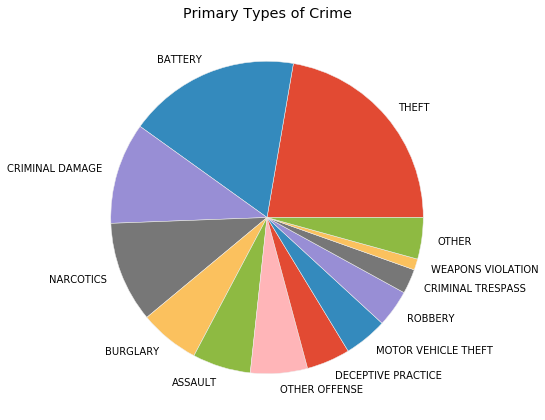

In [35]:
top_crimes = pd.DataFrame(combined["Primary Type"].value_counts() /
                          combined["Primary Type"].value_counts().sum())

remaining_pct = 1 - top_crimes[top_crimes["Primary Type"] > 0.01].sum()
other = pd.DataFrame({"Primary Type": remaining_pct.item()}, index=['OTHER'])

# Will replace tiny slices with an "other" slice
top_crimes = top_crimes.append(other)

top_crimes_for_pie = top_crimes[top_crimes["Primary Type"] > 0.01][
    "Primary Type"]

top_crimes_for_pie.name = " " # Name was showing up on the chart.

top_crimes_for_pie.plot(kind="pie", figsize=(7, 7),
                        title="Primary Types of Crime")


So, theft, battery, and criminal damage would take up fully half of the crime coverage!  So, what about at a more detailed level?  We all freak out about crimes like "home invasion", is it anywhere in the list?

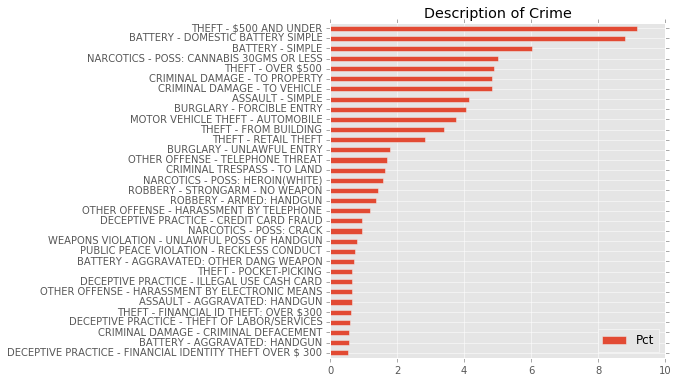

In [36]:
# Found a cool way to group by a combination of fields...
groups = combined.groupby(combined["Primary Type"] +
                          " - " + combined["Description"])

top_crimes2 = pd.DataFrame(groups.size(), columns=['Pct'])
top_crimes2 = top_crimes2.sort_values("Pct", ascending=False)

total = sum(top_crimes2.Pct)

top_crimes2 = top_crimes2 / total * 100

top_crimes2[top_crimes2.Pct > 0.5].plot(kind="barh",
                                        figsize=(6, 6),
                                        title="Description of Crime"
                                        ).invert_yaxis()


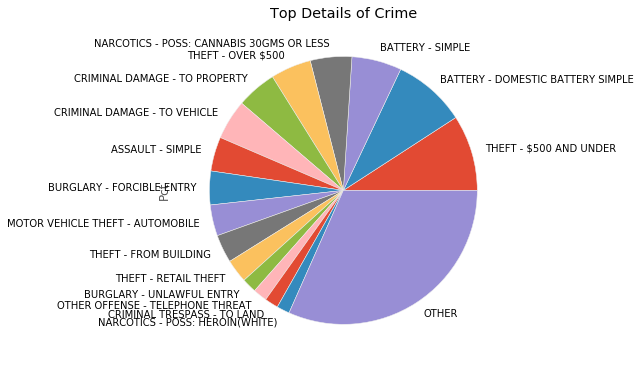

In [37]:
# Let's do it again as a pie chart...
top_crimes_for_pie = top_crimes2[top_crimes2["Pct"] > 1.5]

# if fields add up to nearly 1, pie leaves a gap for missing %
top_crimes_for_pie = top_crimes_for_pie / 100

missing_slice = pd.DataFrame({'Pct': float(1-top_crimes_for_pie.sum())},
                             index=['OTHER'])

top_crimes_for_pie = top_crimes_for_pie.append(missing_slice)

top_crimes_for_pie["Pct"].plot(kind="Pie", figsize=(6, 6),
                               title="Top Details of Crime")


In [38]:
# So where is "home invasion"??
100 * combined[combined["Description"] ==
               "HOME INVASION"]["Description"].value_counts() \
                / total_crimes

# That's not 8.5%, that's 0.085%!  Not too scary!


HOME INVASION    0.085532
Name: Description, dtype: float64